# Removing losses from rainfall profiles
The rainfall input which is required by the Hec-Ras model is the net rainfall, after losses have been subtracted (this is something to do with Hec-Ras not being able to model losses to infiltration etc). To get this net rainfall the synthetic rainfall profiles are input into ReFH2, antecedent conditions are provided, and a .csv file which includes the rainfall with losses removed is output.

This script plots the rainfall both pre and post loss removal for the two methods of generating synthetic rainfall events. 

NB: Rural profiles have not been updated from when we re-run with summer events rather than winter events. SO this no longer includes the rural profiles

In [63]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import matplotlib.patches as mpatches
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

roberto_profiles_fp = "RobertoProfiles/"
multiple_peaks_fp =  "MultiplePeaks/"

total_duration_minutes = 60* 6 

## Multiple peaks

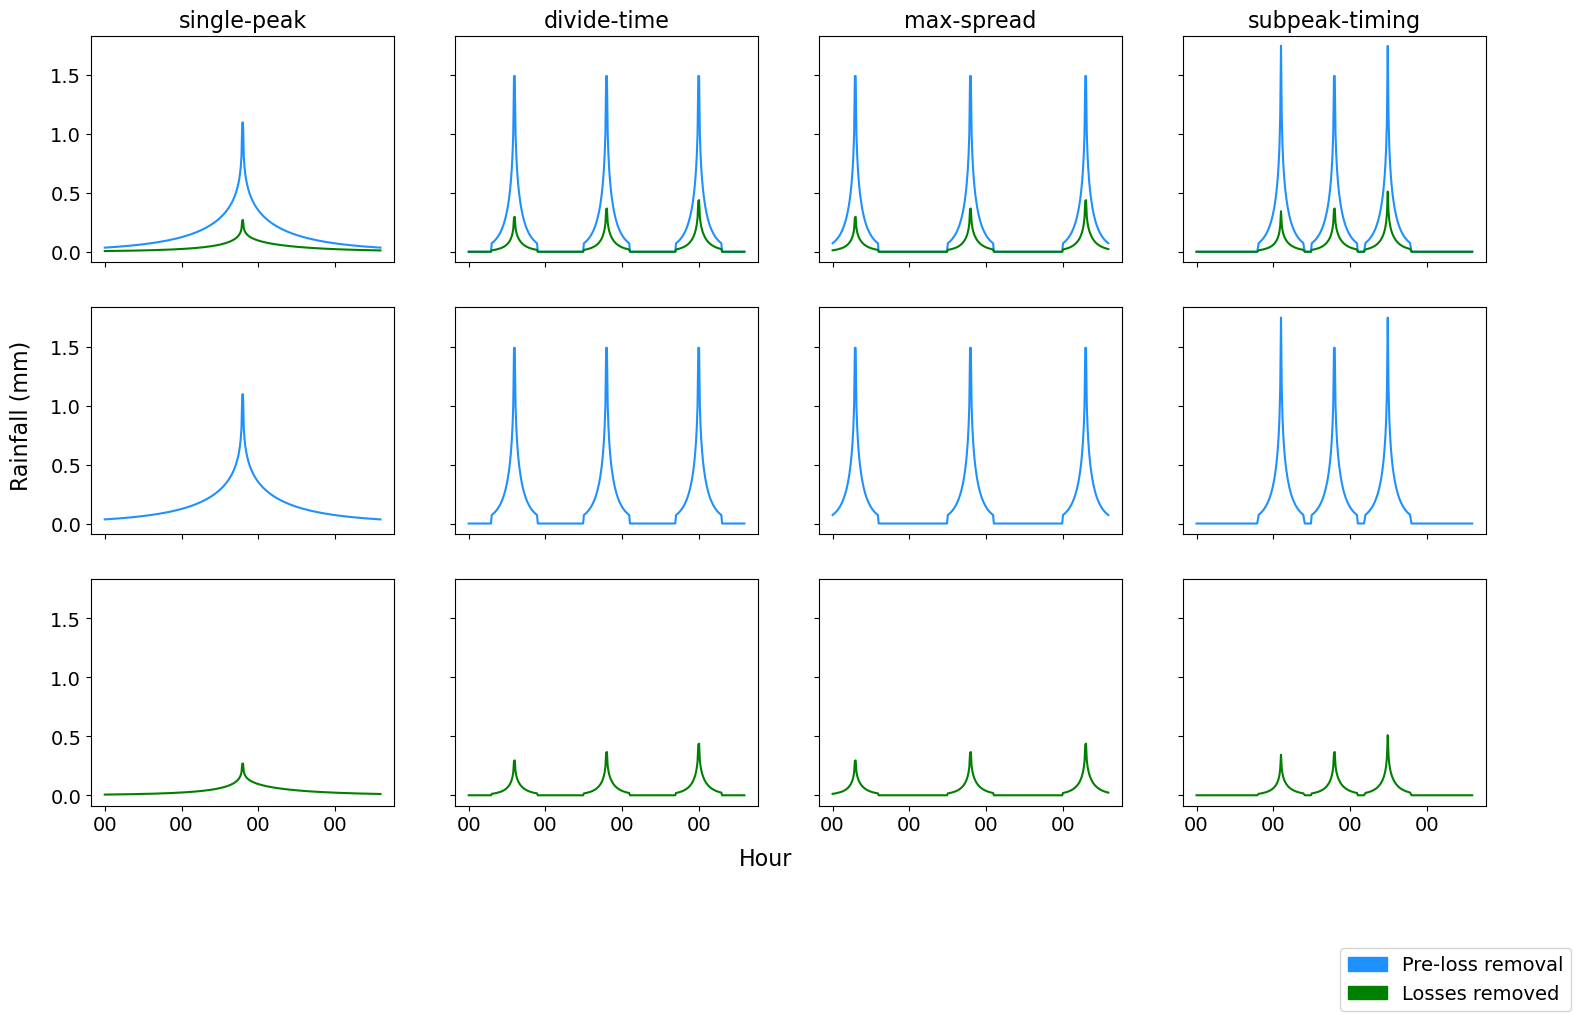

In [70]:
methods=['single-peak','divide-time','max-spread','subpeak-timing']
durations = ['1h', '3h', '6h']

# Set size of x/y tick labels in all subplots
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Create figure
fig, axes = plt.subplots(3, len(methods), figsize=(18,10), sharex =True, sharey = True)

# Set title on columns
for ax, col in zip(axes[0], methods):
    ax.set_title(col, size =16)
    
# Read in data
for axes_number, method in enumerate(methods):
    
    pre_loss_removal = pd.read_csv(multiple_peaks_fp + "PreLossRemoval/6h/6h_{}.csv".format(method), names = ['Time', 'Rainfall'])
    post_loss_removal = pd.read_csv(multiple_peaks_fp + "PostLossRemoval/6h/6h_{}_urban.csv".format(method))
    
    # Filter to only include those within the first 6 hours
    post_loss_removal = post_loss_removal[:360]
    
    # Convert date to datetime
    pre_loss_removal['Time'] =  np.array(range(total_duration_minutes))
    post_loss_removal['Time'] =  np.array(range(total_duration_minutes))    
    
    # PLot
    axes[0, axes_number].plot(pre_loss_removal['Time'], pre_loss_removal['Rainfall'], color = 'dodgerblue')
    axes[0, axes_number].plot(post_loss_removal['Time'], post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], color = 'green')

    axes[1, axes_number].plot(pre_loss_removal['Time'], pre_loss_removal['Rainfall'], color = 'dodgerblue')
    axes[2, axes_number].plot(post_loss_removal['Time'], post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], color = 'green')
   
    myFmt = mdates.DateFormatter('%H')
    axes[2, axes_number].xaxis.set_major_formatter(myFmt)
    
fig.text(0.5, 0.05, 'Hour', ha='center', size =16)
fig.text(0.08, 0.5, 'Rainfall (mm)', va='center', rotation='vertical', size = 16)    

green_patch = mpatches.Patch(color='green', label='Losses removed')
blue_patch = mpatches.Patch(color='dodgerblue', label='Pre-loss removal')
plt.legend(handles=[blue_patch, green_patch], loc="lower center", fontsize= 14, bbox_to_anchor=(0.5, -0.95));

## Roberto profiles:

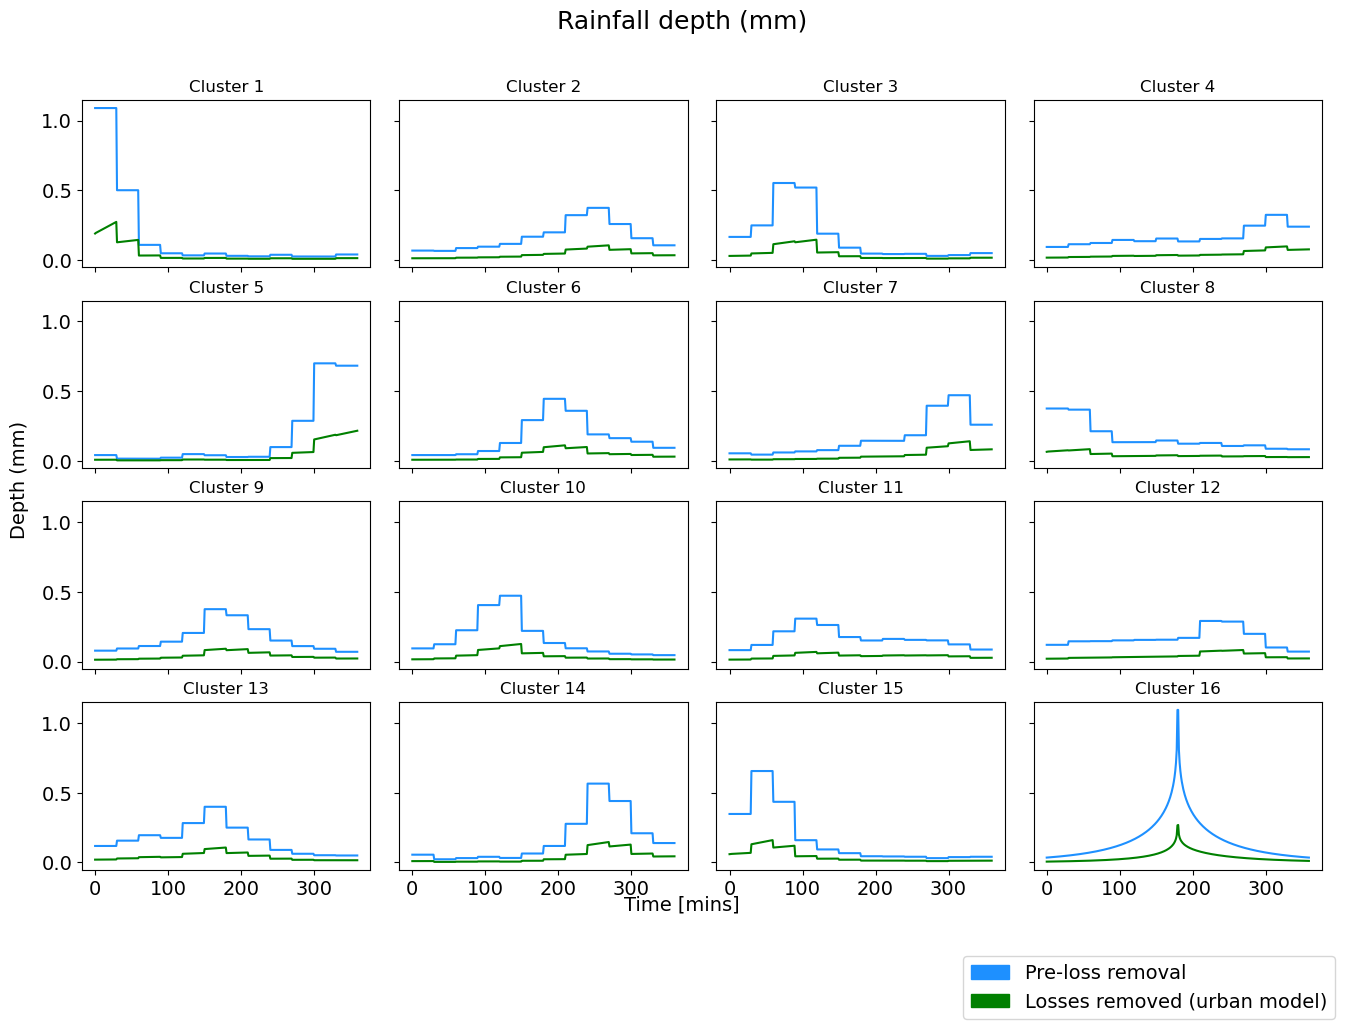

In [40]:
# Define cluster numbers (one extra for FEH single peak plot)
clusters =[*range(1, 17, 1)]

# Plot
fig, axs = plt.subplots(nrows=4, ncols=4, figsize =(16,10), sharey=True, sharex = True)
plt.subplots_adjust(wspace=0.1)
fig.suptitle("Rainfall depth (mm)", fontsize=18, y=0.97)
      
# loop through tickers and axes
for axes_number, cluster_num in enumerate(clusters):
    if cluster_num == 16:
            pre_loss_removal = pd.read_csv(multiple_peaks_fp + "PreLossRemoval/6h/6h_{}.csv".format('single-peak'), names = ['Time', 'Rainfall'])
            post_loss_removal = pd.read_csv(multiple_peaks_fp + "PostLossRemoval/6h/6h_{}_urban.csv".format('single-peak'))
    else:
        pre_loss_removal = pd.read_csv(roberto_profiles_fp + "PreLossRemoval/6hr_100yrRP/cluster{}.csv".format(cluster_num), names = ['Time', 'Rainfall'])
        post_loss_removal = pd.read_csv(roberto_profiles_fp + "PostLossRemoval/6hr_100yrRP/cluster{}_urban_summer.csv".format(cluster_num))

    ax = axs.ravel()[cluster_num-1]
    
    # Convert date to datetime
    pre_loss_removal['Time'] =  np.array(range(total_duration_minutes))
    post_loss_removal['Time'] = pd.to_datetime(post_loss_removal['Time'])

    # Filter to only include those within the first 6 hours
    start_time = post_loss_removal['Time'].loc[0]
    end_time = start_time + timedelta(hours=6) - timedelta(minutes=1)
    post_loss_removal = post_loss_removal[(post_loss_removal['Time'] >= start_time) & (post_loss_removal['Time'] <= end_time)]

    # Make dates 1-360 as better for plotting
    pre_loss_removal['Time'] =  np.array(range(total_duration_minutes))
    post_loss_removal['Time'] =  np.array(range(total_duration_minutes))    
    
    ax.plot(pre_loss_removal['Time'], pre_loss_removal['Rainfall'], color = 'dodgerblue')
    ax.plot(post_loss_removal['Time'], post_loss_removal[post_loss_removal.columns[5]], color = 'green')
    
    # Add plot subtitles
    if cluster_num == 0:
        ax.set_title("FEH profile")
    else:
        ax.set_title("Cluster {}".format(cluster_num))
        
fig.text(0.5, 0.07, 'Time [mins]', ha='center', fontsize =14)
fig.text(0.08, 0.5, "Depth (mm)", va='center', rotation='vertical', fontsize =14)

# Legend
green_patch = mpatches.Patch(color='green', label='Losses removed (urban model)')
blue_patch = mpatches.Patch(color='dodgerblue', label='Pre-loss removal')
# gold_patch = mpatches.Patch(color='gold', label='Losses removed (rural model)')
plt.legend(handles=[blue_patch, green_patch], loc="lower center", fontsize= 14, bbox_to_anchor=(0.4, -0.95));

# Find difference between pre- and post- loss removal in max rainfall rate

In [44]:
max_rain_rate_reductions = pd.DataFrame(None)
# Loop thru clusters
for cluster_num in range(1,16):
    # Read in pre and post loss removal data
    pre_loss_removal = pd.read_csv("RobertoProfiles/PreLossRemoval/6hr_100yrRP/cluster{}.csv".format(cluster_num), names = ['Time', 'Rainfall'])
    post_loss_removal = pd.read_csv("RobertoProfiles/PostLossRemoval/6hr_100yrRP/cluster{}_urban_summer.csv".format(cluster_num))
    # Find differnce between max rain rate before loss removal and max rate after
    diff = pre_loss_removal['Rainfall'].max() - post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].max()
    # Find the difference between the timing of max rain rate in this cluster and for the single-peaked profile
    minute_of_max_rain_rate = pre_loss_removal['Rainfall'].idxmax()
    # Create row and add to dataframe
    row = pd.DataFrame({'Cluster': cluster_num, 'Difference':round(diff/pre_loss_removal['Rainfall'].max() * 100,1),
                       'Minute of max rain rate': minute_of_max_rain_rate}, index = [cluster_num])
    max_rain_rate_reductions = max_rain_rate_reductions.append(row)
# Sort
max_rain_rate_reductions = max_rain_rate_reductions.sort_values(by=['Difference'])

## Plot the relationship between the difference in pre and post max rainfall rate and the timing of this maximum rainfall rate

This shows that the earlier in the event that the maximum rainfall rate occurs, the greater the reduction in the maximum rainfall rate

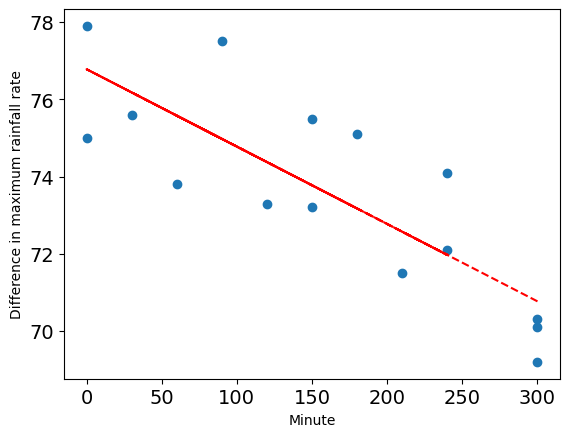

In [45]:
plt.scatter(max_rain_rate_reductions['Minute of max rain rate'], max_rain_rate_reductions['Difference'])
plt.xlabel('Minute')
plt.ylabel('Difference in maximum rainfall rate')

z = np.polyfit(max_rain_rate_reductions['Minute of max rain rate'],max_rain_rate_reductions['Difference'], 1)
p = np.poly1d(z)
plt.plot(max_rain_rate_reductions['Minute of max rain rate'],p(max_rain_rate_reductions['Minute of max rain rate']),"r--")

plt.show()

In [48]:
max_rain_rate_reductions = pd.DataFrame(None)
# Loop thru clusters
for cluster_num in range(1,16):
    # Read in pre and post loss removal data
    pre_loss_removal = pd.read_csv("RobertoProfiles/PreLossRemoval/6hr_100yrRP/cluster{}.csv".format(cluster_num), names = ['Time', 'Rainfall'])
    post_loss_removal = pd.read_csv("RobertoProfiles/PostLossRemoval/6hr_100yrRP/cluster{}_urban_summer.csv".format(cluster_num))   